In [3]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import json

from datetime import datetime, timedelta

## Pandas

In [4]:
# Read the Parquet file into a Pandas DataFrame
raw_df = pd.read_parquet("USDT_IDRT.parquet")

# Display the DataFrame
raw_df

,coin,opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote
0,USDT,1587096000000,15603.0,15603.0,3500.0,3800.0,2111.00,1587096059999,7950998.02,12,180.42,665115.90
1,USDT,1587096060000,3900.0,9999.0,3121.0,9999.0,1518.80,1587096119999,8007685.55,30,569.40,4303589.21
2,USDT,1587096120000,9999.0,15400.0,3121.0,15300.0,3436.21,1587096179999,48425887.45,26,1093.32,15982700.25
3,USDT,1587096180000,15300.0,15399.0,3905.0,13662.0,2006.86,1587096239999,25022275.06,20,21.70,334158.30
4,USDT,1587096240000,13662.0,15000.0,3905.0,15000.0,1858.21,1587096299999,21579335.19,25,473.01,6156983.66
...,...,...,...,...,...,...,...,...,...,...,...,...
2375391,USDT,1729727700000,15691.0,15691.0,15691.0,15691.0,0.00,1729727759999,0.00,0,0.00,0.00
2375392,USDT,1729727760000,15691.0,15691.0,15691.0,15691.0,0.00,1729727819999,0.00,0,0.00,0.00
2375393,USDT,1729727820000,15691.0,15691.0,15691.0,15691.0,5.00,1729727879999,78455.00,1,0.00,0.00
2375394,USDT,1729727880000,15693.0,15693.0,15693.0,15693.0,5.00,1729727939999,78465.00,1,5.00,78465.00


In [5]:
# Convert opentime and closetime to datetime format
raw_df['opentime'] = pd.to_datetime(raw_df['opentime'], unit='ms')
raw_df['closetime'] = pd.to_datetime(raw_df['closetime'], unit='ms')

# Display the DataFrame to verify the changes
raw_df

,coin,opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote
0,USDT,2020-04-17 04:00:00,15603.0,15603.0,3500.0,3800.0,2111.00,2020-04-17 04:00:59.999,7950998.02,12,180.42,665115.90
1,USDT,2020-04-17 04:01:00,3900.0,9999.0,3121.0,9999.0,1518.80,2020-04-17 04:01:59.999,8007685.55,30,569.40,4303589.21
2,USDT,2020-04-17 04:02:00,9999.0,15400.0,3121.0,15300.0,3436.21,2020-04-17 04:02:59.999,48425887.45,26,1093.32,15982700.25
3,USDT,2020-04-17 04:03:00,15300.0,15399.0,3905.0,13662.0,2006.86,2020-04-17 04:03:59.999,25022275.06,20,21.70,334158.30
4,USDT,2020-04-17 04:04:00,13662.0,15000.0,3905.0,15000.0,1858.21,2020-04-17 04:04:59.999,21579335.19,25,473.01,6156983.66
...,...,...,...,...,...,...,...,...,...,...,...,...
2375391,USDT,2024-10-23 23:55:00,15691.0,15691.0,15691.0,15691.0,0.00,2024-10-23 23:55:59.999,0.00,0,0.00,0.00
2375392,USDT,2024-10-23 23:56:00,15691.0,15691.0,15691.0,15691.0,0.00,2024-10-23 23:56:59.999,0.00,0,0.00,0.00
2375393,USDT,2024-10-23 23:57:00,15691.0,15691.0,15691.0,15691.0,5.00,2024-10-23 23:57:59.999,78455.00,1,0.00,0.00
2375394,USDT,2024-10-23 23:58:00,15693.0,15693.0,15693.0,15693.0,5.00,2024-10-23 23:58:59.999,78465.00,1,5.00,78465.00


In [6]:
# Keeping necessary columns for aggregation
binance_df = raw_df[['opentime','closetime','openprice','highprice','lowprice','closeprice']]

# Ensure 'opentime' is in datetime format to group by date
binance_df['opentime'] = pd.to_datetime(binance_df['opentime'])

# Group by the date part of 'opentime' and apply the required aggregations
aggregated_df = binance_df.groupby(binance_df['opentime'].dt.date).agg(
    openprice=('openprice', 'first'),   # First open price of the day
    highprice=('highprice', 'max'),     # Highest price of the day
    lowprice=('lowprice', 'min'),       # Lowest price of the day
    closeprice=('closeprice', 'last')   # Last close price of the day
).reset_index()

# Rename the date column for clarity
aggregated_df.rename(columns={'opentime': 'date'}, inplace=True)

# Display the resulting DataFrame
aggregated_df

C:\Users\pc\AppData\Local\Temp\ipykernel_21096\1661086334.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binance_df['opentime'] = pd.to_datetime(binance_df['opentime'])


,date,openprice,highprice,lowprice,closeprice
0,2020-04-17,15603.0,16000.0,3121.0,15503.0
1,2020-04-18,15503.0,15690.0,15367.0,15367.0
2,2020-04-19,15367.0,15698.0,15367.0,15415.0
3,2020-04-20,15421.0,15899.0,15410.0,15485.0
4,2020-04-21,15485.0,15993.0,15440.0,15911.0
...,...,...,...,...,...
1646,2024-10-19,15528.0,15528.0,15500.0,15501.0
1647,2024-10-20,15501.0,15525.0,15480.0,15481.0
1648,2024-10-21,15481.0,15580.0,15425.0,15573.0
1649,2024-10-22,15573.0,15630.0,15556.0,15602.0


In [10]:
aggregated_df[aggregated_df['date'] > 2007-12-30]

TypeError: '>' not supported between instances of 'datetime.date' and 'int'

In [19]:
import pandas as pd

# Check if 'date' is sorted in ascending order
is_sorted = aggregated_df['date'].is_monotonic_increasing
print("Is the DataFrame sorted by date in ascending order?", is_sorted)

# Generate a complete date range from the minimum to maximum date
full_date_range = pd.date_range(start=aggregated_df['date'].min(), end=aggregated_df['date'].max(), freq='D')

# Find missing dates by comparing with the full date range
missing_dates = full_date_range.difference(aggregated_df['date'])
print("Missing dates:", missing_dates)

# Display the minimum and maximum dates in the DataFrame
min_date = aggregated_df['date'].min()
max_date = aggregated_df['date'].max()
print("Minimum date:", min_date)
print("Maximum date:", max_date)

Is the DataFrame sorted by date in ascending order? True
Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Minimum date: 2020-04-17
Maximum date: 2024-10-23


## Bloomberg data

In [14]:
raw_bloomberg_df = pd.read_csv('usd_idr_data.csv', header=1)

raw_bloomberg_df = raw_bloomberg_df.rename(columns={'Unnamed: 0': 'Datetime'})

raw_bloomberg_df

,Datetime,PX_OPEN,PX_LAST,PX_HIGH,PX_LOW,BID,ASK,PX_MID,high,low
0,1991-11-05,1977.0,1977.0,1977.0,1977.0,NaN,NaN,1977.0,1977.0,1977.0
1,1991-11-06,1977.0,1977.0,1977.0,1977.0,NaN,NaN,1977.0,1977.0,1977.0
2,1991-11-07,1977.0,1977.0,1977.0,1977.0,NaN,NaN,1977.0,1977.0,1977.0
3,1991-11-08,1977.0,1977.0,1977.0,1977.0,NaN,NaN,1977.0,1977.0,1977.0
4,1991-11-11,1977.0,1977.0,1977.0,1977.0,NaN,NaN,1977.0,1977.0,1977.0
...,...,...,...,...,...,...,...,...,...,...
8379,2024-10-22,15534.0,15560.0,15572.0,15534.0,15555.0,15565.0,15560.0,15572.0,15534.0
8380,2024-10-23,15590.0,15620.0,15633.0,15590.0,15615.0,15625.0,15620.0,15633.0,15590.0
8381,2024-10-24,15640.0,15584.0,15644.0,15580.0,15583.0,15585.0,15584.0,15644.0,15580.0
8382,2024-10-25,15622.0,15640.0,15643.0,15603.0,15635.0,15645.0,15640.0,15643.0,15603.0


In [16]:
# Get necessary columns and renaming
bloomberg_df = raw_bloomberg_df[['Datetime','PX_OPEN','PX_HIGH','PX_LOW','PX_LAST']]
                                
bloomberg_df                            

,Datetime,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST
0,1991-11-05,1977.0,1977.0,1977.0,1977.0
1,1991-11-06,1977.0,1977.0,1977.0,1977.0
2,1991-11-07,1977.0,1977.0,1977.0,1977.0
3,1991-11-08,1977.0,1977.0,1977.0,1977.0
4,1991-11-11,1977.0,1977.0,1977.0,1977.0
...,...,...,...,...,...
8379,2024-10-22,15534.0,15572.0,15534.0,15560.0
8380,2024-10-23,15590.0,15633.0,15590.0,15620.0
8381,2024-10-24,15640.0,15644.0,15580.0,15584.0
8382,2024-10-25,15622.0,15643.0,15603.0,15640.0


In [21]:
# Filtering data according to binance usdt/idrt data

# Convert 'Datetime' column to datetime format if it's not already
bloomberg_df['Datetime'] = pd.to_datetime(bloomberg_df['Datetime'])

# Define the minimum and maximum dates
min_datetime = pd.Timestamp('2020-04-17')
max_datetime = pd.Timestamp('2024-10-23')

# Filter the DataFrame
filtered_bloomberg_df = bloomberg_df[(bloomberg_df['Datetime'] >= min_datetime) & (bloomberg_df['Datetime'] <= max_datetime)]

# Display the filtered DataFrame
filtered_bloomberg_df

C:\Users\pc\AppData\Local\Temp\ipykernel_5716\550988053.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloomberg_df['Datetime'] = pd.to_datetime(bloomberg_df['Datetime'])


,Datetime,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST
7288,2020-04-17,15505.0,15540.0,15438.0,15465.0
7289,2020-04-20,15470.0,15507.0,15413.0,15413.0
7290,2020-04-21,15507.0,15583.0,15468.0,15468.0
7291,2020-04-22,15530.0,15585.0,15450.0,15450.0
7292,2020-04-23,15524.0,15598.0,15415.0,15415.0
...,...,...,...,...,...
8376,2024-10-17,15548.0,15553.0,15490.0,15495.0
8377,2024-10-18,15523.0,15523.0,15447.0,15465.0
8378,2024-10-21,15463.0,15498.0,15431.0,15495.0
8379,2024-10-22,15534.0,15572.0,15534.0,15560.0


## Comparing

In [23]:
# Assuming filtered_bloomberg_df and aggregated_df are already defined

# First, ensure the 'date' column in aggregated_df is in the same datetime format as the 'Datetime' column
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])

# Perform the left join
joined_df = filtered_bloomberg_df.merge(aggregated_df, how='left', left_on='Datetime', right_on='date')

# Calculate the absolute percentage differences
joined_df['open_diff'] = abs((joined_df['openprice'] - joined_df['PX_OPEN']) / joined_df['PX_OPEN'] * 100)
joined_df['high_diff'] = abs((joined_df['highprice'] - joined_df['PX_HIGH']) / joined_df['PX_HIGH'] * 100)
joined_df['low_diff'] = abs((joined_df['lowprice'] - joined_df['PX_LOW']) / joined_df['PX_LOW'] * 100)
joined_df['close_diff'] = abs((joined_df['closeprice'] - joined_df['PX_LAST']) / joined_df['PX_LAST'] * 100)

# Display the result
joined_df

,Datetime,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,date,openprice,highprice,lowprice,closeprice,open_diff,high_diff,low_diff,close_diff
0,2020-04-17,15505.0,15540.0,15438.0,15465.0,2020-04-17,15603.0,16000.0,3121.0,15503.0,0.632054,2.960103,79.783651,0.245716
1,2020-04-20,15470.0,15507.0,15413.0,15413.0,2020-04-20,15421.0,15899.0,15410.0,15485.0,0.316742,2.527891,0.019464,0.467138
2,2020-04-21,15507.0,15583.0,15468.0,15468.0,2020-04-21,15485.0,15993.0,15440.0,15911.0,0.141871,2.631072,0.181019,2.863977
3,2020-04-22,15530.0,15585.0,15450.0,15450.0,2020-04-22,15911.0,15921.0,15460.0,15749.0,2.453316,2.155919,0.064725,1.935275
4,2020-04-23,15524.0,15598.0,15415.0,15415.0,2020-04-23,15749.0,15749.0,15422.0,15720.0,1.449369,0.968073,0.045410,1.978592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,2024-10-17,15548.0,15553.0,15490.0,15495.0,2024-10-17,15542.0,15570.0,15518.0,15569.0,0.038590,0.109304,0.180762,0.477573
1089,2024-10-18,15523.0,15523.0,15447.0,15465.0,2024-10-18,15569.0,15570.0,15465.0,15528.0,0.296334,0.302777,0.116527,0.407371
1090,2024-10-21,15463.0,15498.0,15431.0,15495.0,2024-10-21,15481.0,15580.0,15425.0,15573.0,0.116407,0.529101,0.038883,0.503388
1091,2024-10-22,15534.0,15572.0,15534.0,15560.0,2024-10-22,15573.0,15630.0,15556.0,15602.0,0.251062,0.372463,0.141625,0.269923


In [24]:
# Calculate Max, Min, and Avg for each diff column
diff_stats = {
    'open_diff_max': joined_df['open_diff'].max(),
    'open_diff_min': joined_df['open_diff'].min(),
    'open_diff_avg': joined_df['open_diff'].mean(),
    
    'high_diff_max': joined_df['high_diff'].max(),
    'high_diff_min': joined_df['high_diff'].min(),
    'high_diff_avg': joined_df['high_diff'].mean(),
    
    'low_diff_max': joined_df['low_diff'].max(),
    'low_diff_min': joined_df['low_diff'].min(),
    'low_diff_avg': joined_df['low_diff'].mean(),
    
    'close_diff_max': joined_df['close_diff'].max(),
    'close_diff_min': joined_df['close_diff'].min(),
    'close_diff_avg': joined_df['close_diff'].mean(),
}

# Display the statistics
diff_stats

{'open_diff_max': np.float64(7.338626164998274),
 'open_diff_min': np.float64(0.0),
 'open_diff_avg': np.float64(0.5759360254300163),
 'high_diff_max': np.float64(371.66142591285376),
 'high_diff_min': np.float64(0.0),
 'high_diff_avg': np.float64(1.5561937122541896),
 'low_diff_max': np.float64(79.7836507319601),
 'low_diff_min': np.float64(0.0),
 'low_diff_avg': np.float64(0.5810132280553748),
 'close_diff_max': np.float64(6.866923288424526),
 'close_diff_min': np.float64(0.0),
 'close_diff_avg': np.float64(0.5271092323929182)}

In [36]:
n = 25

# Filter the rows where any of the _diff columns are greater than n%
filtered_diff = joined_df[(joined_df['open_diff'] > n) | 
                           (joined_df['high_diff'] > n) | 
                           (joined_df['low_diff'] > n) | 
                           (joined_df['close_diff'] > n)]

# Display the result
filtered_diff

,Datetime,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,date,openprice,highprice,lowprice,closeprice,open_diff,high_diff,low_diff,close_diff
0,2020-04-17,15505.0,15540.0,15438.0,15465.0,2020-04-17,15603.0,16000.0,3121.0,15503.0,0.632054,2.960103,79.783651,0.245716
615,2022-10-27,15553.0,15583.0,15553.0,15568.0,2022-10-27,15595.0,73499.0,15540.0,15576.0,0.270044,371.661426,0.083585,0.051387
637,2022-11-28,15693.0,15737.0,15693.0,15723.0,2022-11-28,15795.0,15970.0,8800.0,15820.0,0.649971,1.480587,43.924043,0.616931
1036,2024-08-05,16180.0,16198.0,16127.0,16185.0,2024-08-05,16384.0,73499.0,16251.0,16397.0,1.260816,353.753550,0.768897,1.309855


In [37]:
# Remove rows where any of the _diff columns have a value greater than 25
cleaned_diff = joined_df[(joined_df['open_diff'] <= 25) & 
                          (joined_df['high_diff'] <= 25) & 
                          (joined_df['low_diff'] <= 25) & 
                          (joined_df['close_diff'] <= 25)]

# Calculate the averages of the remaining _diff columns
avg_diffs = {
    'avg_open_diff': cleaned_diff['open_diff'].mean(),
    'avg_high_diff': cleaned_diff['high_diff'].mean(),
    'avg_low_diff': cleaned_diff['low_diff'].mean(),
    'avg_close_diff': cleaned_diff['close_diff'].mean()
}

# Display the average differences
avg_diffs

{'avg_open_diff': np.float64(0.575468494130126),
 'avg_high_diff': np.float64(0.8917025359491346),
 'avg_low_diff': np.float64(0.46876701829604106),
 'avg_close_diff': np.float64(0.5270032157904122)}

## Polars

In [ ]:
# Read parquet file
raw_df = pl.read_parquet("USDT_IDRT.parquet")

# Display the DataFrame
raw_df

In [122]:
# Calculate average, IQR, and prepare for Z-scores
summary_data = []

# Select numerical columns (excluding 'opentime' and 'closetime')
numeric_columns = raw_df.columns[2:]  # Exclude 'coin', 'opentime', 'closetime'

for col in numeric_columns:
    mean = raw_df[col].mean()
    q1 = raw_df[col].quantile(0.25)
    q3 = raw_df[col].quantile(0.75)
    iqr = q3 - q1
    std = raw_df[col].std()

    # Append summary statistics to the list
    summary_data.append({
        "column": col,
        "mean": mean,
        "IQR": iqr,
    })

# Create summary DataFrame
summary_df = pl.DataFrame(summary_data)

# Calculate Z-scores and create a new DataFrame for Z-scores
z_score_data = {col: ((raw_df[col] - raw_df[col].mean()) / raw_df[col].std()).to_list() for col in numeric_columns}

# Create Z-scores DataFrame
z_scores_df = pl.DataFrame(z_score_data)

# Display the summary DataFrame
print("Summary Statistics:")
print(summary_df)

# Display the Z-scores DataFrame
print("\nZ-scores:")
print(z_scores_df)

Summary Statistics:
shape: (10, 3)
┌──────────────────┬──────────────┬───────────┐
│ column           ┆ mean         ┆ IQR       │
│ ---              ┆ ---          ┆ ---       │
│ str              ┆ f64          ┆ f64       │
╞══════════════════╪══════════════╪═══════════╡
│ openprice        ┆ 15011.614879 ┆ 1099.0    │
│ highprice        ┆ 15012.716087 ┆ 1097.0    │
│ lowprice         ┆ 15010.750935 ┆ 1098.0    │
│ closeprice       ┆ 15011.7771   ┆ 1098.0    │
│ volume           ┆ 237.893948   ┆ 15.89     │
│ closetime        ┆ 1.6584e12    ┆ 7.1290e10 │
│ quotevolume      ┆ 3.5600e6     ┆ 233209.04 │
│ trades           ┆ 1.361487     ┆ 1.0       │
│ taker_buy_volume ┆ 126.383688   ┆ 0.0       │
│ taker_buy_quote  ┆ 1.9112e6     ┆ 0.0       │
└──────────────────┴──────────────┴───────────┘

Z-scores:
shape: (2_375_396, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ openprice ┆ highprice ┆ lowprice  ┆ closepric ┆ … ┆ quotevol

In [108]:
import polars as pl
import matplotlib.pyplot as plt

def plot_open_price_vs_column(df, column_name):
    """
    Plots the 'opentime' against the specified column in the DataFrame.
    
    Parameters:
        df (pl.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot against 'opentime'.
    """
    # Extract data for plotting
    opentime_data = df["opentime"].to_numpy()  # Convert to numpy array
    column_data = df[column_name].to_numpy()  # Convert to numpy array

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(opentime_data, column_data, marker='o')
    plt.title(f"{column_name} Over Time")
    plt.xlabel("Open Time (Milliseconds since Epoch)")
    plt.ylabel(column_name)

    # Set the x-axis limits based on the actual open time range
    plt.xlim([opentime_data.min(), opentime_data.max()])  # Set x limits to data range

    # Rotate x-axis labels for better readability (optional)
    plt.xticks(rotation=45)

    plt.grid()
    plt.tight_layout()
    plt.show()

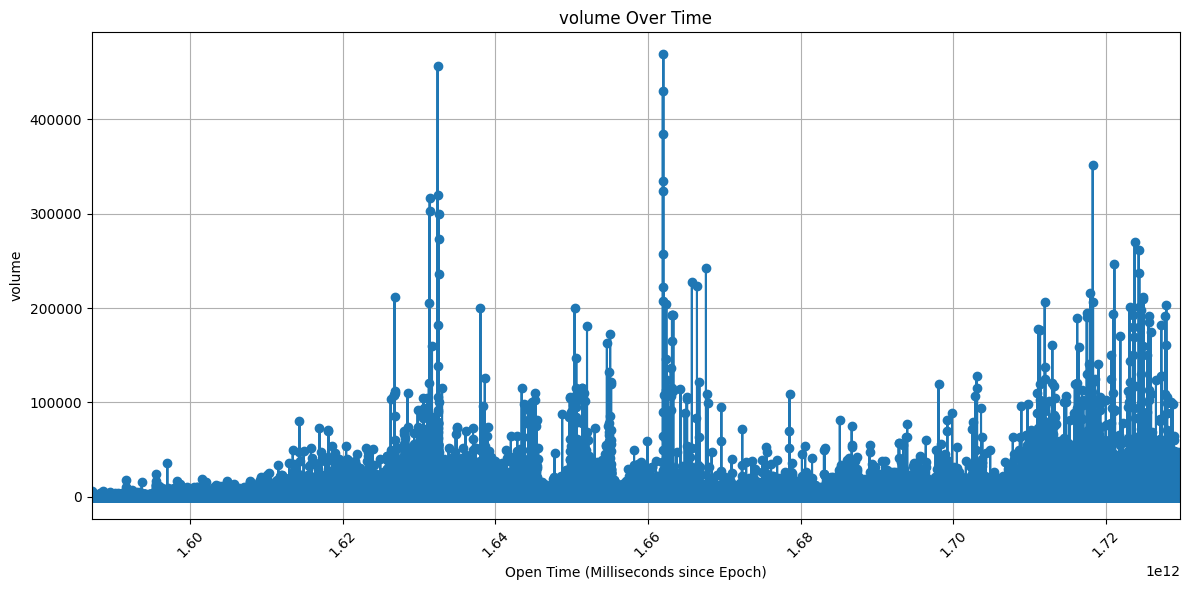

In [127]:
# ['coin',
#  'opentime',
#  'openprice',
#  'highprice',
#  'lowprice',
#  'closeprice',
#  'volume',
#  'closetime',
#  'quotevolume',
#  'trades',
#  'taker_buy_volume',
#  'taker_buy_quote']
plot_open_price_vs_column(raw_df, "volume")

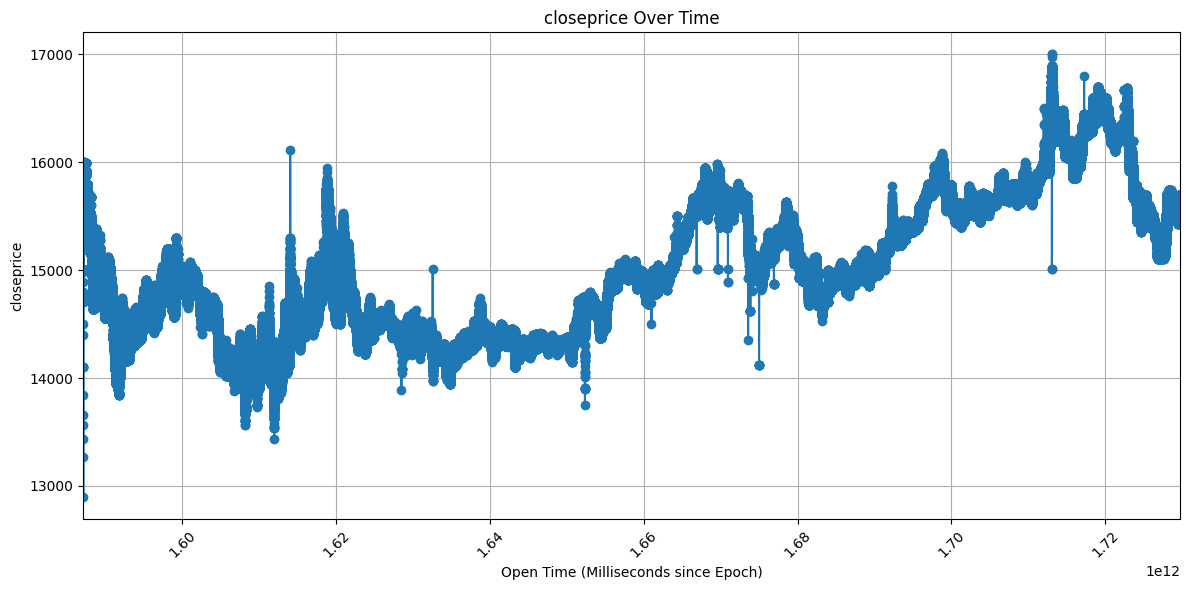

In [135]:
# ['coin',
#  'opentime',
#  'openprice',
#  'highprice',
#  'lowprice',
#  'closeprice',
#  'volume',
#  'closetime',
#  'quotevolume',
#  'trades',
#  'taker_buy_volume',
#  'taker_buy_quote']
plot_open_price_vs_column(df_averaged, "closeprice")

In [131]:
import polars as pl

# Calculate mean and IQR
def replace_outliers_with_mean(df, cols):
    for col in cols:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        # Calculate lower and upper bounds for outliers
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Calculate mean
        mean_value = df[col].mean()
        
        # Replace outliers with mean
        df = df.with_columns(
            pl.when((pl.col(col) < lower_bound) | (pl.col(col) > upper_bound))
                    .then(mean_value)
                    .otherwise(pl.col(col))
                    .alias(col)
        )
    return df

# Columns to process
columns_to_process = ['openprice', 'highprice', 'lowprice', 'closeprice']

# Replace outliers
df_averaged = replace_outliers_with_mean(raw_df, columns_to_process)

# Display the cleaned DataFrame
df_averaged

coin,opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote
str,i64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64
"""USDT""",1587096000000,15603.0,15603.0,15010.750935,15011.7771,2111.0,1587096059999,7.9510e6,12,180.42,665115.9
"""USDT""",1587096060000,15011.614879,15012.716087,15010.750935,15011.7771,1518.8,1587096119999,8.0077e6,30,569.4,4.3036e6
"""USDT""",1587096120000,15011.614879,15400.0,15010.750935,15300.0,3436.21,1587096179999,4.8426e7,26,1093.32,1.5983e7
"""USDT""",1587096180000,15300.0,15399.0,15010.750935,13662.0,2006.86,1587096239999,2.5022e7,20,21.7,334158.3
"""USDT""",1587096240000,13662.0,15000.0,15010.750935,15000.0,1858.21,1587096299999,2.1579e7,25,473.01,6.1570e6
…,…,…,…,…,…,…,…,…,…,…,…
"""USDT""",1729727700000,15691.0,15691.0,15691.0,15691.0,0.0,1729727759999,0.0,0,0.0,0.0
"""USDT""",1729727760000,15691.0,15691.0,15691.0,15691.0,0.0,1729727819999,0.0,0,0.0,0.0
"""USDT""",1729727820000,15691.0,15691.0,15691.0,15691.0,5.0,1729727879999,78455.0,1,0.0,0.0


In [193]:
# Features engineering
df = raw_df.with_columns([
    # Maker Buy
    (pl.col("volume") - pl.col("taker_buy_volume")).alias("maker_buy_volume"),
    (pl.col("quotevolume") - pl.col("taker_buy_quote")).alias("maker_buy_quote_volume"),

    # Price Deltas
    (pl.col("closeprice") - pl.col("openprice")).alias("open_close_delta"),
    (pl.col("highprice") - pl.col("lowprice")).alias("low_high_delta"),
    (pl.col("highprice") - pl.col("openprice")).alias("high_open_delta"),
    (pl.col("closeprice") / pl.col("openprice") - 1).alias("close_open_ratio"),
    
    # Moving Averages
    pl.col("closeprice").rolling_mean(window_size=5).alias("sma_5"),
    pl.col("closeprice").rolling_mean(window_size=10).alias("sma_10"),
    
    # Changes from lag_1
    (pl.col("volume") - pl.col("volume").shift(1)).alias("volume_change"),
    
    # Taker vs Maker Volume Ratio
    (pl.col("taker_buy_volume") / (pl.col("volume") - pl.col("taker_buy_volume"))).alias("volume_ratio"),
    
    # Lagged Features (next close and volume)
    pl.col("closeprice").shift(-1).alias("next_closeprice"),  # Next close price


])

df = df.drop(["coin"])

# Function to replace NaN and infinite values in specified columns
def replace_nan_inf(df: pl.DataFrame, col_names: list, replacement: float = 0) -> pl.DataFrame:
    for col in col_names:
        df = df.with_columns(
            pl.when(pl.col(col).is_nan() | pl.col(col).is_in([np.inf, -np.inf]))
            .then(replacement)
            .otherwise(pl.col(col)).alias(col)
        )
    return df

# List of columns to replace NaN and infinite values with 0
columns_to_replace = [
    "volume_ratio", "maker_buy_volume", "maker_buy_quote_volume",
    "open_close_delta", "low_high_delta", "high_open_delta",
    "close_open_ratio", "sma_5", "sma_10", "volume_change",
    "next_closeprice"
]

# Replace NaN and infinite values with 0 using the utility function
df = replace_nan_inf(df, columns_to_replace)

# Calculate change from previous lag for specified columns
columns_to_change = [
    'opentime','openprice', 'highprice', 'lowprice', 'closeprice', 'closetime', 'volume', 
    'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 
    'maker_buy_volume', 'maker_buy_quote_volume', 'open_close_delta', 
    'low_high_delta', 'high_open_delta', 'close_open_ratio', 
    'sma_5', 'sma_10', 'volume_change', 'volume_ratio', 
    'next_closeprice'
]

# Calculate the change and create new columns
for col in columns_to_change:
    change_col_name = f"{col}_change"
    df = df.with_columns(
        (pl.col(col) - pl.col(col).shift(1)).alias(change_col_name)  # Calculate the change
    )

# Display the updated DataFrame
df

opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote,maker_buy_volume,maker_buy_quote_volume,open_close_delta,low_high_delta,high_open_delta,close_open_ratio,sma_5,sma_10,volume_change,volume_ratio,next_closeprice,opentime_change,openprice_change,highprice_change,lowprice_change,closeprice_change,closetime_change,quotevolume_change,trades_change,taker_buy_volume_change,taker_buy_quote_change,maker_buy_volume_change,maker_buy_quote_volume_change,open_close_delta_change,low_high_delta_change,high_open_delta_change,close_open_ratio_change,sma_5_change,sma_10_change,volume_change_change,volume_ratio_change,next_closeprice_change
i64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1587096000000,15603.0,15603.0,3500.0,3800.0,2111.0,1587096059999,7.9510e6,12,180.42,665115.9,1930.58,7.2859e6,-11803.0,12103.0,0.0,-0.756457,null,null,null,0.093454,9999.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1587096060000,3900.0,9999.0,3121.0,9999.0,1518.8,1587096119999,8.0077e6,30,569.4,4.3036e6,949.4,3.7041e6,6099.0,6878.0,6099.0,1.563846,null,null,-592.2,0.599747,15300.0,60000,-11703.0,-5604.0,-379.0,6199.0,60000,56687.53,18,388.98,3.6385e6,-981.18,-3.5818e6,17902.0,-5225.0,6099.0,2.320303,null,null,null,0.506293,5301.0
1587096120000,9999.0,15400.0,3121.0,15300.0,3436.21,1587096179999,4.8426e7,26,1093.32,1.5983e7,2342.89,3.2443e7,5301.0,12279.0,5401.0,0.530153,null,null,1917.41,0.466654,13662.0,60000,6099.0,5401.0,0.0,5301.0,60000,4.0418e7,-4,523.92,1.1679e7,1393.49,2.8739e7,-798.0,5401.0,-698.0,-1.033693,null,null,2509.61,-0.133093,-1638.0
1587096180000,15300.0,15399.0,3905.0,13662.0,2006.86,1587096239999,2.5022e7,20,21.7,334158.3,1985.16,2.4688e7,-1638.0,11494.0,99.0,-0.107059,null,null,-1429.35,0.010931,15000.0,60000,5301.0,-1.0,784.0,-1638.0,60000,-2.3404e7,-6,-1071.62,-1.5649e7,-357.73,-7.7551e6,-6939.0,-785.0,-5302.0,-0.637212,null,null,-3346.76,-0.455723,1338.0
1587096240000,13662.0,15000.0,3905.0,15000.0,1858.21,1587096299999,2.1579e7,25,473.01,6.1570e6,1385.2,1.5422e7,1338.0,11095.0,1338.0,0.097936,11552.2,null,-148.65,0.341474,14994.0,60000,-1638.0,-399.0,0.0,1338.0,60000,-3.4429e6,5,451.31,5.8228e6,-599.96,-9.2658e6,2976.0,-399.0,1239.0,0.204995,null,null,1280.7,0.330543,-6.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1729727700000,15691.0,15691.0,15691.0,15691.0,0.0,1729727759999,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,0.0,15691.0,60000,0.0,0.0,0.0,0.0,60000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1729727760000,15691.0,15691.0,15691.0,15691.0,0.0,1729727819999,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,0.0,15691.0,60000,0.0,0.0,0.0,0.0,60000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1729727820000,15691.0,15691.0,15691.0,15691.0,5.0,1729727879999,78455.0,1,0.0,0.0,5.0,78455.0,0.0,0.0,0.0,0.0,15691.0,15691.0,5.0,0.0,15693.0,60000,0.0,0.0,0.0,0.0,60000,78455.0,1,0.0,0.0,5.0,78455.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0


In [194]:
# Drop rows where 'opentime_change' is not equal to 60000
df = df.filter(pl.col("opentime_change") == 60000)

df = df.filter(pl.col("closetime_change") == 60000)

df

 Number of row dropped: 10


opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote,maker_buy_volume,maker_buy_quote_volume,open_close_delta,low_high_delta,high_open_delta,close_open_ratio,sma_5,sma_10,volume_change,volume_ratio,next_closeprice,opentime_change,openprice_change,highprice_change,lowprice_change,closeprice_change,closetime_change,quotevolume_change,trades_change,taker_buy_volume_change,taker_buy_quote_change,maker_buy_volume_change,maker_buy_quote_volume_change,open_close_delta_change,low_high_delta_change,high_open_delta_change,close_open_ratio_change,sma_5_change,sma_10_change,volume_change_change,volume_ratio_change,next_closeprice_change
i64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1587096600000,12900.0,15000.0,8000.0,8000.0,1584.33,1587096659999,2.0138e7,29,930.78,1.2430e7,653.55,7.7084e6,-4900.0,7000.0,2100.0,-0.379845,12350.0,13070.5,-1636.21,1.424191,14892.0,60000,4899.0,1450.0,-1.0,-4900.0,60000,-2.1873e7,-8,-1205.77,-1.5740e7,-430.44,-6.1325e6,-9799.0,1451.0,-3449.0,-0.992143,-1398.8,420.0,-2994.64,-0.546814,6892.0
1587096660000,8005.0,14894.0,8005.0,14892.0,1659.71,1587096719999,2.1179e7,20,683.71,1.0004e7,976.0,1.1175e7,6887.0,6889.0,6889.0,0.860337,12559.2,13559.8,75.38,0.700523,14101.0,60000,-4895.0,-106.0,5.0,6892.0,60000,1.0411e6,-9,-247.07,-2.4253e6,322.45,3.4665e6,11787.0,-111.0,4789.0,1.240182,209.2,489.3,1711.59,-0.723668,-791.0
1587096720000,13988.0,14800.0,13988.0,14101.0,1174.44,1587096779999,1.7111e7,21,626.66,9.2604e6,547.78,7.8505e6,113.0,812.0,812.0,0.008078,12665.6,13439.9,-485.27,1.143999,14101.0,60000,5983.0,-94.0,5983.0,-791.0,60000,-4.0682e6,1,-57.05,-743803.75,-428.22,-3.3244e6,-6774.0,-6077.0,-6077.0,-0.852259,106.4,-119.9,-560.65,0.443477,0.0
1587096780000,14102.0,14707.0,14101.0,14101.0,1217.85,1587096839999,1.7320e7,19,428.83,6.0469e6,789.02,1.1273e7,-1.0,606.0,605.0,-0.000071,12798.8,13483.8,43.41,0.543497,14101.0,60000,114.0,-93.0,113.0,0.0,60000,209237.08,-2,-197.83,-3.2135e6,241.24,3.4227e6,-114.0,-206.0,-207.0,-0.008149,133.2,43.9,528.68,-0.600502,0.0
1587096840000,14101.0,14101.0,13846.0,14101.0,922.44,1587096899999,1.2968e7,14,555.22,7.8291e6,367.22,5.1385e6,0.0,255.0,0.0,0.0,13039.0,13393.9,-295.41,1.511955,10526.0,60000,-1.0,-606.0,-255.0,0.0,60000,-4.3524e6,-5,126.39,1.7822e6,-421.8,-6.1346e6,1.0,-351.0,-605.0,0.000071,240.2,-89.9,-338.82,0.968458,-3575.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1729727640000,15691.0,15691.0,15691.0,15691.0,0.0,1729727699999,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,0.0,15691.0,60000,0.0,0.0,0.0,0.0,60000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1729727700000,15691.0,15691.0,15691.0,15691.0,0.0,1729727759999,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,0.0,15691.0,60000,0.0,0.0,0.0,0.0,60000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1729727760000,15691.0,15691.0,15691.0,15691.0,0.0,1729727819999,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,0.0,15691.0,60000,0.0,0.0,0.0,0.0,60000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
 # Original number of rows
original_row_count = df.height

# Clean the DataFrame by dropping null values
df_cleaned = df.drop_nulls()

# Number of rows after cleaning
cleaned_row_count = df_cleaned.height

# Count of dropped rows
dropped_row_count = original_row_count - cleaned_row_count

# Display the count of dropped rows
print(f" Number of row dropped: {dropped_row_count}")
      
df_cleaned

 Number of row dropped: 10


opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote,maker_buy_volume,maker_buy_quote_volume,open_close_delta,low_high_delta,high_open_delta,close_open_ratio,sma_5,sma_10,volume_change,volume_ratio,next_closeprice,opentime_change,openprice_change,highprice_change,lowprice_change,closeprice_change,closetime_change,quotevolume_change,trades_change,taker_buy_volume_change,taker_buy_quote_change,maker_buy_volume_change,maker_buy_quote_volume_change,open_close_delta_change,low_high_delta_change,high_open_delta_change,close_open_ratio_change,sma_5_change,sma_10_change,volume_change_change,volume_ratio_change,next_closeprice_change
i64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1587096600000,12900.0,15000.0,8000.0,8000.0,1584.33,1587096659999,2.0138e7,29,930.78,1.2430e7,653.55,7.7084e6,-4900.0,7000.0,2100.0,-0.379845,12350.0,13070.5,-1636.21,1.424191,14892.0,60000,4899.0,1450.0,-1.0,-4900.0,60000,-2.1873e7,-8,-1205.77,-1.5740e7,-430.44,-6.1325e6,-9799.0,1451.0,-3449.0,-0.992143,-1398.8,420.0,-2994.64,-0.546814,6892.0
1587096660000,8005.0,14894.0,8005.0,14892.0,1659.71,1587096719999,2.1179e7,20,683.71,1.0004e7,976.0,1.1175e7,6887.0,6889.0,6889.0,0.860337,12559.2,13559.8,75.38,0.700523,14101.0,60000,-4895.0,-106.0,5.0,6892.0,60000,1.0411e6,-9,-247.07,-2.4253e6,322.45,3.4665e6,11787.0,-111.0,4789.0,1.240182,209.2,489.3,1711.59,-0.723668,-791.0
1587096720000,13988.0,14800.0,13988.0,14101.0,1174.44,1587096779999,1.7111e7,21,626.66,9.2604e6,547.78,7.8505e6,113.0,812.0,812.0,0.008078,12665.6,13439.9,-485.27,1.143999,14101.0,60000,5983.0,-94.0,5983.0,-791.0,60000,-4.0682e6,1,-57.05,-743803.75,-428.22,-3.3244e6,-6774.0,-6077.0,-6077.0,-0.852259,106.4,-119.9,-560.65,0.443477,0.0
1587096780000,14102.0,14707.0,14101.0,14101.0,1217.85,1587096839999,1.7320e7,19,428.83,6.0469e6,789.02,1.1273e7,-1.0,606.0,605.0,-0.000071,12798.8,13483.8,43.41,0.543497,14101.0,60000,114.0,-93.0,113.0,0.0,60000,209237.08,-2,-197.83,-3.2135e6,241.24,3.4227e6,-114.0,-206.0,-207.0,-0.008149,133.2,43.9,528.68,-0.600502,0.0
1587096840000,14101.0,14101.0,13846.0,14101.0,922.44,1587096899999,1.2968e7,14,555.22,7.8291e6,367.22,5.1385e6,0.0,255.0,0.0,0.0,13039.0,13393.9,-295.41,1.511955,10526.0,60000,-1.0,-606.0,-255.0,0.0,60000,-4.3524e6,-5,126.39,1.7822e6,-421.8,-6.1346e6,1.0,-351.0,-605.0,0.000071,240.2,-89.9,-338.82,0.968458,-3575.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1729727640000,15691.0,15691.0,15691.0,15691.0,0.0,1729727699999,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,0.0,15691.0,60000,0.0,0.0,0.0,0.0,60000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1729727700000,15691.0,15691.0,15691.0,15691.0,0.0,1729727759999,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,0.0,15691.0,60000,0.0,0.0,0.0,0.0,60000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1729727760000,15691.0,15691.0,15691.0,15691.0,0.0,1729727819999,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,0.0,15691.0,60000,0.0,0.0,0.0,0.0,60000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
df['opentime_change'].unique()

opentime_change
i64
60000


In [196]:
# # Calculate the frequency of unique values in the 'opentime_change' column
# opentime_change_frequency = df.group_by("opentime_change").agg(
#     pl.count().alias("frequency")
# ).sort("opentime_change")

# # Display the result
# print(opentime_change_frequency)

shape: (1, 2)
┌─────────────────┬───────────┐
│ opentime_change ┆ frequency │
│ ---             ┆ ---       │
│ i64             ┆ u32       │
╞═════════════════╪═══════════╡
│ 60000           ┆ 2375378   │
└─────────────────┴───────────┘


C:\Users\pc\AppData\Local\Temp\ipykernel_11596\2192345708.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("frequency")


In [198]:
# # Calculate the frequency of unique values in the 'closetime_change' column
# closetime_change_frequency = df.group_by("closetime_change").agg(
#     pl.count().alias("frequency")
# ).sort("closetime_change")

# # Display the result
# print(closetime_change_frequency)

shape: (1, 2)
┌──────────────────┬───────────┐
│ closetime_change ┆ frequency │
│ ---              ┆ ---       │
│ i64              ┆ u32       │
╞══════════════════╪═══════════╡
│ 60000            ┆ 2375378   │
└──────────────────┴───────────┘


C:\Users\pc\AppData\Local\Temp\ipykernel_11596\2994949304.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("frequency")


In [45]:
# # To findout which columns has null value

# # Assuming df is your DataFrame
# # Get null counts for each column
# null_counts = df.null_count()

# # Create a list of column names that have null values
# null_column_names = null_counts.select(pl.col("*") > 0).columns

# # Filter to get names of columns with nulls
# null_column_names = [col for col in null_counts.columns if null_counts[col][0] > 0]

# # Display the names of columns that have null values
# print(null_column_names)

In [138]:
# Selecting feature for the model
features = [
    "openprice", 
    "highprice", 
    "lowprice", 
    "closeprice", 
    "volume", 
    "volume_ratio", 
    "open_close_delta", 
    "low_high_delta", 
    "sma_5", 
    "sma_10", 
    "close_open_ratio", 
    "closeprice_lag_-1" 
]

# Create a new DataFrame with selected features
df_features = df_cleaned.select(features)

# Display the new DataFrame with selected features
df_features

openprice,highprice,lowprice,closeprice,volume,volume_ratio,open_close_delta,low_high_delta,sma_5,sma_10,close_open_ratio,closeprice_lag_-1
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
8001.0,13550.0,8001.0,12900.0,3220.54,1.971005,4899.0,5549.0,13748.8,12650.5,0.612298,8000.0
12900.0,15000.0,8000.0,8000.0,1584.33,1.424191,-4900.0,7000.0,12350.0,13070.5,-0.379845,14892.0
8005.0,14894.0,8005.0,14892.0,1659.71,0.700523,6887.0,6889.0,12559.2,13559.8,0.860337,14101.0
13988.0,14800.0,13988.0,14101.0,1174.44,1.143999,113.0,812.0,12665.6,13439.9,0.008078,14101.0
14102.0,14707.0,14101.0,14101.0,1217.85,0.543497,-1.0,606.0,12798.8,13483.8,-0.000071,14101.0
…,…,…,…,…,…,…,…,…,…,…,…
15691.0,15691.0,15691.0,15691.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,15691.0
15691.0,15691.0,15691.0,15691.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,15691.0
15691.0,15691.0,15691.0,15691.0,0.0,0.0,0.0,0.0,15691.0,15691.0,0.0,15691.0


In [139]:
# Calculate the mean of each column
column_means = df_features.select([pl.col(col).mean().alias(col) for col in df_features.columns])

# Calculate the correlation of each column with closeprice_lag_-1
correlation_with_target = df_features.select([
    pl.corr(pl.col(col), pl.col("closeprice_lag_-1")).alias(f"corr_with_{col}") for col in df_features.columns if col != "closeprice_lag_-1"
])

# Display results
print("Column Means:")
print(column_means)

print("\nCorrelation with closeprice_lag_-1:")
print(correlation_with_target)

Column Means:
shape: (1, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ openprice ┆ highprice ┆ lowprice  ┆ closepric ┆ … ┆ sma_5     ┆ sma_10    ┆ close_ope ┆ closepri │
│ ---       ┆ ---       ┆ ---       ┆ e         ┆   ┆ ---       ┆ ---       ┆ n_ratio   ┆ ce_lag_- │
│ f64       ┆ f64       ┆ f64       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ 1        │
│           ┆           ┆           ┆ f64       ┆   ┆           ┆           ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 15011.630 ┆ 15012.718 ┆ 15010.788 ┆ 15011.785 ┆ … ┆ 15011.784 ┆ 15011.782 ┆ 0.000011  ┆ 15011.78 │
│ 46        ┆ 454       ┆ 642       ┆ 865       ┆   ┆ 199       ┆ 059       ┆           ┆ 7041     │
└───────────┴───────────┴───────────┴───────────┴───┴─────────

In [140]:
correlation_with_target

corr_with_openprice,corr_with_highprice,corr_with_lowprice,corr_with_closeprice,corr_with_volume,corr_with_volume_ratio,corr_with_open_close_delta,corr_with_low_high_delta,corr_with_sma_5,corr_with_sma_10,corr_with_close_open_ratio
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.994426,0.99447,0.994265,0.99616,-0.007737,-0.003274,0.055323,0.028604,0.995585,0.995764,0.052441


In [141]:
# Part 1: Import Libraries and Prepare Data

import polars as pl
import torch

# Load or define your DataFrame (df_features) here
# Example: df_features = pl.read_csv("your_data.csv")

# Features and target
X = df_features.select(pl.all().exclude("closeprice_lag_-1"))  # All columns except the target
y = df_features["closeprice_lag_-1"]  # Target variable

# Convert to NumPy and then to tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
y_tensor = torch.tensor(y.to_numpy(), dtype=torch.float32)

In [142]:
# Part 2: Split Data into Training and Validation Sets

# Set a random seed for reproducibility
torch.manual_seed(0)

# Determine the number of samples
num_samples = X_tensor.shape[0]
train_size = int(0.8 * num_samples)

# Shuffle the indices
indices = torch.randperm(num_samples)

# Split indices for training and validation
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create training and validation sets
X_train, y_train = X_tensor[train_indices], y_tensor[train_indices]
X_val, y_val = X_tensor[val_indices], y_tensor[val_indices]

# Display the shapes of the training and validation sets
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")

Training set shape: torch.Size([1900308, 11]), Validation set shape: torch.Size([475078, 11])


In [143]:
# Part 3: Define the Model

import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # First layer
        self.fc2 = nn.Linear(64, 32)           # Second layer
        self.fc3 = nn.Linear(32, 1)            # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))            # Activation function
        x = torch.relu(self.fc2(x))            # Activation function
        x = self.fc3(x)                        # Output
        return x

# Initialize the model
input_size = X_train.shape[1]  # Number of features
model = SimpleModel(input_size)

In [144]:
# Part 4: Define Loss Function and Optimizer

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [147]:
# Part 5: Training Loop

num_epochs = 150  # Number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)  # Compute loss

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear gradients
    loss.backward()        # Backpropagation
    optimizer.step()       # Update weights

    if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/150], Loss: 3936.2336
Epoch [20/150], Loss: 3399.1956
Epoch [30/150], Loss: 3508.8665
Epoch [40/150], Loss: 3413.2126
Epoch [50/150], Loss: 3321.0312
Epoch [60/150], Loss: 3282.2817
Epoch [70/150], Loss: 3265.2192
Epoch [80/150], Loss: 3252.1448
Epoch [90/150], Loss: 3239.6038
Epoch [100/150], Loss: 3227.5654
Epoch [110/150], Loss: 3216.0942
Epoch [120/150], Loss: 3205.4812
Epoch [130/150], Loss: 3195.6250
Epoch [140/150], Loss: 3186.2170
Epoch [150/150], Loss: 3177.2227


In [148]:
# Part 6: Validation

# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs.squeeze(), y_val)

# Calculate RMSE
rmse = torch.sqrt(val_loss)
average_closeprice = y_val.mean()  # Get the average of the target closeprice in validation data
percentage_loss = (rmse / average_closeprice) * 100  # Calculate the loss as a percentage of the average closeprice

print(f'Validation Loss: {val_loss.item():.4f}')
print(f'RMSE: {rmse.item():.4f}')
print(f'Percentage Loss (RMSE relative to avg closeprice): {percentage_loss.item():.2f}%')

Validation Loss: 229.0702
RMSE: 15.1351
Percentage Loss (RMSE relative to avg closeprice): 0.10%
